In [1]:
## Import libraries
import sys
from tqdm import trange

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch import nn
from torch.utils.data import TensorDataset

source = "../source"
sys.path.append(source)

from preprocessing import Encoding
from compilation import Compiler, ScalarTracker, ActivationTracker
import publication
import simulate
import models

device = torch.device("cpu")

save = True

/tmp/ipykernel_27180/2647203504.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
## Load settings
settings = "default"

(
    model_type,
    nonlinearity,
    gain,
    lr,
    P,
    L,
    n_epochs,
    hidden_layer,
    dx2,
    dy2,
    in_dim,
    out_dim,
) = (
    pd.read_csv("model_settings/2 points.txt", sep=" ", header=0)
    .loc[settings]
    .to_numpy()
)
model_type = getattr(models, model_type)

if nonlinearity == "none":
    nonlinearity = None
else:
    nonlinearity = getattr(torch.nn.functional, nonlinearity)

In [3]:
## Generate data
input_dim, output_dim = in_dim, out_dim

inputs = np.array([[-1] * input_dim, [-1 + np.sqrt(dx2)] * input_dim]) / np.sqrt(
    input_dim
)
outputs = np.array([[0.6] * output_dim, [0.6 + np.sqrt(dy2)] * output_dim]) / np.sqrt(
    output_dim
)
names = ["A", "B"]
data = TensorDataset(
    torch.from_numpy(inputs.astype(np.float32)).to(device),
    torch.from_numpy(outputs.astype(np.float32)).to(device),
)

encoding = Encoding(dict(zip(names, inputs)))

train_datasets = [data]
val_dataset = [data]

tracked_datasets = val_dataset + train_datasets

In [4]:
## Instantiate model
model = model_type(
    encoding=encoding,
    input_size=input_dim,
    output_size=output_dim,
    hidden_dim=P,
    n_hid_layers=L,
    device=device,
    init_std=gain,
    non_linearity=nonlinearity,
)

In [5]:
## Setup compiler
criterion = lambda x, y: 0.5 * nn.functional.mse_loss(x, y)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
compiler = Compiler(model, criterion, optimizer)
compiler.trackers = {
    "loss": ScalarTracker(lambda: compiler.validation(tracked_datasets)),
    "output": ActivationTracker(
        model, lambda inputs: model(inputs)[0], datasets=tracked_datasets
    ),
}
for l in range(L):
    compiler.trackers[f"hidden_{l}"] = ActivationTracker(
        model, lambda inputs, l=l: model(inputs)[1][l], datasets=tracked_datasets
    )

In [6]:
## Training run
compiler.training_run(
    train_datasets,
    tracked_datasets,
    n_epochs=n_epochs,
    batch_size=100,
)

Training: 100%|██████████| 3000/3000 [04:39<00:00, 10.73steps/s, train_loss=0.00000, val_loss=0.00000]


In [7]:
## Get data
data_output = compiler.trackers["output"].get_trace()
epochs = list(set(data_output.index.get_level_values("Epoch")))
epochs.sort()
y_A = [
    np.array(data.loc[epoch, 0, "A"])
    for epoch, data in data_output.query("Dataset == 0").groupby("Epoch")
]
y_B = [
    np.array(data.loc[epoch, 0, "B"])
    for epoch, data in data_output.query("Dataset == 0").groupby("Epoch")
]
y_true_A, y_true_B = outputs[0], outputs[1]
dy2 = np.sum((y_true_B - y_true_A) ** 2)
y2 = np.array([np.sum((y_A[epoch] - y_B[epoch]) ** 2) for epoch in epochs])
w = np.array(
    [
        y2[epoch] - np.dot(y_true_A - y_true_B, y_A[epoch] - y_B[epoch])
        for epoch in epochs
    ]
)

In [8]:
## Fit effective learning rates and plot results
eta_hs, eta_ys, losses = [], [], []
for l in trange(L):
    data_hid = compiler.trackers[f"hidden_{l}"].get_trace()
    epochs = list(set(data_output.index.get_level_values("Epoch")))
    epochs.sort()

    h_A = [
        np.array(data.loc[epoch, 0, "A"])
        for epoch, data in data_hid.query("Dataset == 0").groupby("Epoch")
    ]
    h_B = [
        np.array(data.loc[epoch, 0, "B"])
        for epoch, data in data_hid.query("Dataset == 0").groupby("Epoch")
    ]

    h2 = np.array([np.sum((h_A[epoch] - h_B[epoch]) ** 2) for epoch in epochs])

    eta_h_opt, eta_y_opt, loss = simulate.optimize_eta(
        h2, y2, w, dx2, dy2, guesses=np.logspace(-6, 2, 100)
    )
    eta_hs.append(eta_h_opt)
    eta_ys.append(eta_y_opt)
    losses.append(loss)

  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:04<01:17,  4.06s/it]

Loss: 30.500557375366306


 10%|█         | 2/20 [00:17<02:55,  9.75s/it]

Loss: 28.23856384615189


 15%|█▌        | 3/20 [00:25<02:33,  9.03s/it]

Loss: 24.606463671049983


 20%|██        | 4/20 [00:33<02:16,  8.53s/it]

Loss: 20.317776392121722


 25%|██▌       | 5/20 [00:36<01:38,  6.57s/it]

Loss: 15.847380207140507


 30%|███       | 6/20 [00:38<01:10,  5.06s/it]

Loss: 11.304479917490468


 35%|███▌      | 7/20 [00:46<01:14,  5.74s/it]

Loss: 8.116244407527699


 40%|████      | 8/20 [00:48<00:56,  4.73s/it]

Loss: 4.968876234894927


 45%|████▌     | 9/20 [00:53<00:53,  4.85s/it]

Loss: 2.821558911352673


 50%|█████     | 10/20 [00:56<00:41,  4.19s/it]

Loss: 1.6870138678542685


 55%|█████▌    | 11/20 [01:00<00:37,  4.16s/it]

Loss: 0.7956405954478785


 60%|██████    | 12/20 [01:04<00:32,  4.12s/it]

Loss: 0.4081459252740595


 65%|██████▌   | 13/20 [01:07<00:26,  3.79s/it]

Loss: 0.13130374693114827


 70%|███████   | 14/20 [01:12<00:24,  4.03s/it]

Loss: 0.034131048193464644


 75%|███████▌  | 15/20 [01:15<00:18,  3.71s/it]

Loss: 0.08380274966371092


 80%|████████  | 16/20 [01:18<00:14,  3.74s/it]

Loss: 0.2781573254910669


 85%|████████▌ | 17/20 [01:24<00:12,  4.22s/it]

Loss: 0.5955190065503748


 90%|█████████ | 18/20 [01:27<00:07,  3.76s/it]

Loss: 1.0659541709624458


 95%|█████████▌| 19/20 [01:30<00:03,  3.53s/it]

Loss: 1.778983712913122


100%|██████████| 20/20 [01:32<00:00,  4.64s/it]

Loss: 2.9267024372993102


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


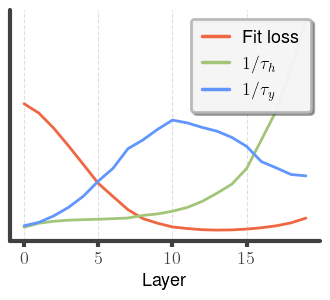

In [10]:
losses, eta_hs, eta_ys = [np.array(a) for a in [losses, eta_hs, eta_ys]]

publication.set_color_mixed(0)
fig = plt.figure(figsize=(4, 3))
publication.skip_colors(6)
plt.plot(0.02 * losses, label="Fit loss")
plt.plot(70 * eta_hs, label=r"$1/\tau_h$")
publication.skip_colors(7)

plt.plot(7 * eta_ys, label=r"$1/\tau_y$")
plt.xlabel("Layer")
legend = plt.legend()
ax = plt.gca()
ax.axes.get_yaxis().set_visible(False)
if save:
    publication.plt_show(save_path="plots/2_points/architecture/depth")
else:
    publication.plt_show()